# 5-layer convolutional neural net

## Keras first, then tensorflow. 
This was suggested by Andrew Ng, since Keras is more suited for developing a model and tensorflow is better for a final deliverable.

In [1]:
from keras import optimizers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from collections import defaultdict
import random

import math
import h5py
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)  
from tensorflow.python.framework import ops
%matplotlib inline
random.seed(100)
%matplotlib inline

Using TensorFlow backend.


In [2]:
#read in the labels and filenames
data_csv = pd.read_csv('train.csv')

In [3]:
#check out the distribution of the data labels to see if we should evaluate precision/recall instead of accuracy 
#it seems reasonable to proceed with accuracy since there is a significant proportion of 1's and 0's
data_csv['has_cactus'].value_counts()

1    13136
0     4364
Name: has_cactus, dtype: int64

In [4]:
#get size of images and number of images
img = load_img('./train/'+data_csv.loc[1]['id'])
img_array = img_to_array(img)
n_h, n_w, n_c = img_array.shape
m = data_csv.shape[0]
print('Image size:', n_h, n_w, n_c)
print('Number of images:',data_csv.shape[0])

Image size: 32 32 3
Number of images: 17500


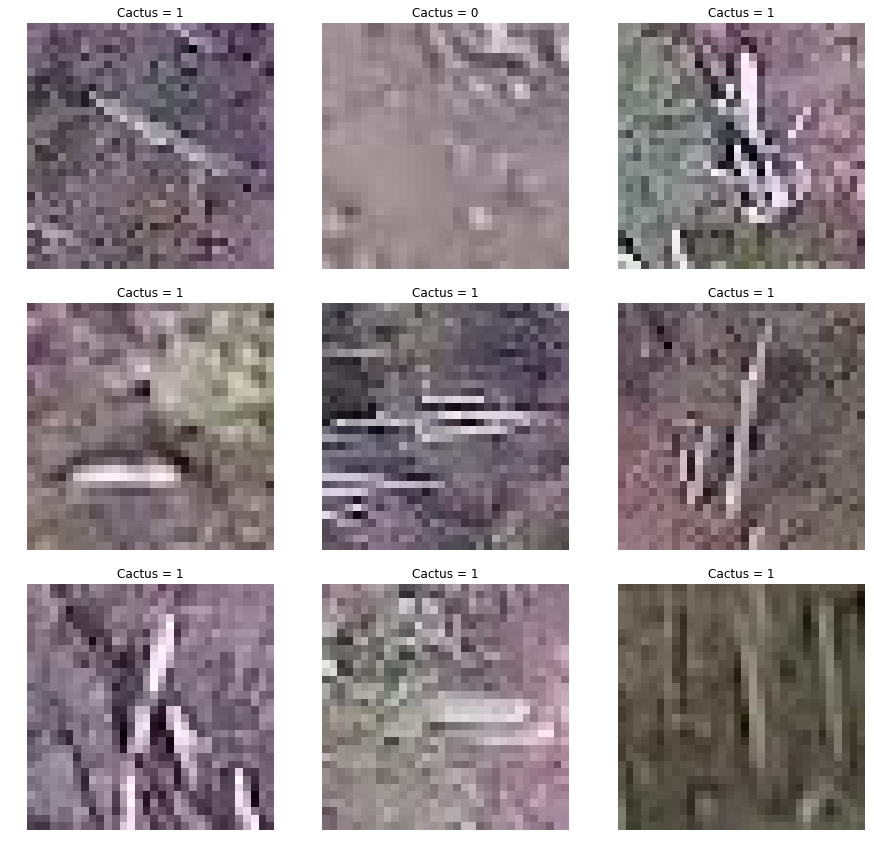

In [5]:
#let's look at the dataset and see what a cactus looks like from an aerial view :)
plt.figure(figsize=(15, 15))
for i in range(1,10,1):
    pic_number = random.randrange(1,17500)
    img = load_img('./train/'+data_csv.loc[pic_number]['id'])
    title = 'Cactus = ' + str(data_csv.loc[pic_number]['has_cactus'])

    curr_plot = int("33" + str(i))
    plt.subplot(curr_plot)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
plt.subplots_adjust(hspace=0.1)
plt.show()

In [6]:
#initialize arrays to hold the image data
full_data = np.zeros((m, n_h, n_w, n_c))
full_labels = np.zeros((m,1))


In [7]:
#load data into arrays
for i, row in data_csv.iterrows():
    img = load_img('./train/'+row.id)
    full_data[i,:,:,:] = img_to_array(img)/255 # load into numpy array and normalize to 255
    full_labels[i] = row.has_cactus # load into numpy array

In [8]:
#split data into 90/10 train/dev sets -- for final result will do 10 fold cross validation 
X_train, X_dev, Y_train, Y_dev = train_test_split(full_data, full_labels, test_size=0.1, random_state=42)

In [9]:
#check array sizes make sense
print(X_train.shape, X_dev.shape, Y_train.shape, Y_dev.shape)

(15750, 32, 32, 3) (1750, 32, 32, 3) (15750, 1) (1750, 1)


In [10]:
#now we'll build a keras model
def make_cactus_model(input_shape):

    X_input = Input(input_shape)

    #First convolutional layer with (8) 3 x 3 filters, batch norm, relu activation, and max pooling
    X = Conv2D(8, (3, 3), strides = (1, 1), name = 'conv_1',padding='same')(X_input)
    X = BatchNormalization(axis = 3, name = 'bn_1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), name='max_pool_1')(X)

    #Second convolutional layer with (16) 3 x 3 filters, batch norm, relu activation, and max pooling
    X = Conv2D(16, (3, 3), strides = (1, 1), name = 'conv_2',padding='same')(X)
    X = BatchNormalization(axis = 3, name = 'bn_2')(X)
    X = Activation('relu',name = 'relu_1')(X)
    X = MaxPooling2D((2, 2), name='max_pool_2')(X)

    #Third convolutional layer with (32) 3 x 3 filters, batch norm, relu activation, and max pooling
    X = Conv2D(32, (3, 3), strides = (2, 2), name = 'conv_3',padding='same')(X)
    X = BatchNormalization(axis = 3, name = 'bn_3')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), name='max_pool_3')(X)

    # turn into a vector and pass to 64 node fully connected relu layer
    X = Flatten()(X)
    X = Dense(64, activation='relu', name='fc_1')(X)
    
    #Single fully conncected sigmoid layer for binary clasification
    X = Dense(1, activation='sigmoid', name='fc_2')(X)

    #Make the model
    model = Model(inputs = X_input, outputs = X, name='make_cactus_model')
    
    return model

In [11]:
#define precision, recall, f1 courtesy of Tasos: datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [12]:
#initialize the model
cactus_model = make_cactus_model((n_h,n_w,n_c))

In [13]:
#Use adam optimization algorithm with 'binary_crossentropy' or log loss since it's a binary classification, and accuracy metric
adam_op = optimizers.Adam(lr=0.009, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

cactus_model.compile(optimizer = adam_op, loss = 'binary_crossentropy', metrics = ["accuracy", precision_m, recall_m, f1_m])

In [14]:
#Run the model for 15 epochs and check the dev set after each epoch
for i in range(20):
    cactus_model.fit(x =X_train, y =Y_train, epochs = 1, batch_size = 64)
    preds = cactus_model.evaluate(x = X_dev, y = Y_dev)
    print ("Test Loss = " + str(preds[0])+"Accuracy = " + str(preds[1]))

Epoch 1/1
1750/1750 [==============================] - 1s 522us/step
Test Loss = 0.09479351876463209Accuracy = 0.964000000340598
Epoch 1/1
1750/1750 [==============================] - 0s 226us/step
Test Loss = 3.69598626599993Accuracy = 0.7531428572109767
Epoch 1/1
1750/1750 [==============================] - 1s 311us/step
Test Loss = 1.462812059674944Accuracy = 0.7548571431296213
Epoch 1/1
1750/1750 [==============================] - 1s 315us/step
Test Loss = 2.754690617152623Accuracy = 0.768571428843907
Epoch 1/1
1750/1750 [==============================] - 1s 328us/step
Test Loss = 0.04461809104654406Accuracy = 0.9828571428571429
Epoch 1/1
1750/1750 [==============================] - 1s 329us/step
Test Loss = 0.0456154200019581Accuracy = 0.9828571428571429
Epoch 1/1
1750/1750 [==============================] - 1s 311us/step
Test Loss = 0.07530076888203621Accuracy = 0.9742857140813556
Epoch 1/1
1750/1750 [==============================] - 1s 320us/step
Test Loss = 2.3597582220349995A

In [15]:
graph = tf.get_default_graph()
with graph.as_default():
    preds = cactus_model.evaluate(x = X_dev, y = Y_dev)

1750/1750 [==============================] - 1s 484us/step


In [16]:
print ("Test Loss = " + str(round(preds[0],3))+" Accuracy = " + str(round(preds[1],3)), " Precision = " + str(round(preds[2],3)),
        " Recall = " + str(round(preds[3],3)),  " F1 score = " + str(round(preds[4],3)))

Test Loss = 0.095 Accuracy = 0.975  Precision = 0.973  Recall = 0.994  F1 score = 0.983


In [17]:
# a summary of the model
print(cactus_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 32, 32, 8)         224       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 32, 32, 8)         32        
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 8)         0         
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 16, 16, 8)         0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 16, 16, 16)        1168      
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 16, 16, 16)        64        
__________

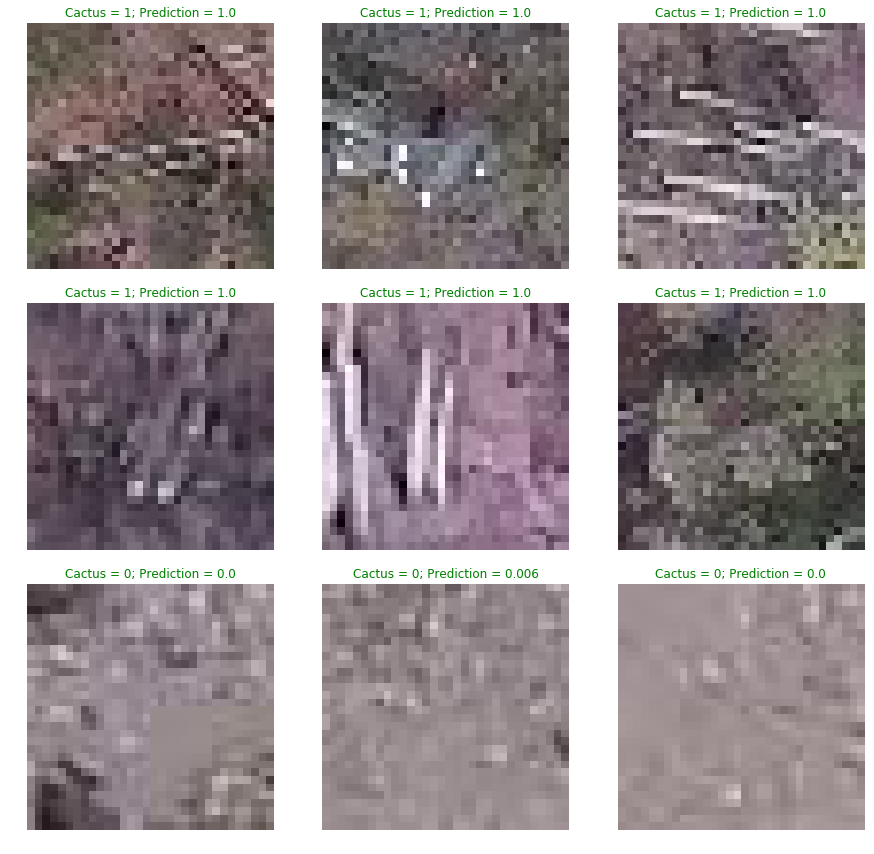

In [18]:
plt.figure(figsize=(15, 15))
for i in range(1,10,1):
    pic_number = random.randrange(1,X_dev.shape[0])
    prediction = round(float(cactus_model.predict(X_dev[pic_number:pic_number+1,:,:,:])),3)
    title = 'Cactus = ' + str(int(Y_dev[pic_number])) + "; Prediction = " + str(prediction)
    curr_plot = int("33" + str(i))
    plt.subplot(curr_plot)
    plt.imshow(X_dev[pic_number,:,:,:])
    title_obj = plt.title(title)
    plt.axis('off')
    if abs(float(Y_dev[pic_number])-prediction) > 0.5:
        plt.setp(title_obj, color='r')
    else:
        plt.setp(title_obj, color='g')
plt.subplots_adjust(hspace=0.1)
plt.show()

### Now let's implement the same CNN in Tensorflow with 10-fold cross-validation
I used Keras with Tensorflow as the backend for the previous section. I'll now build it in Tensorflow as well for more a more robust implementation. This was suggested by Andrew Ng in the Deep Learning course, since Keras is more suited for developing a model and tensorflow is better for a final deliverable.

I'll use 10-fold cross-validation, rather than a simple 90/10 train/test split. This will give us more robust evaluation of the model metrics.

In [19]:
full_data.shape, full_labels.shape

((17500, 32, 32, 3), (17500, 1))

In [20]:
# switch to one hot for Y for tensorflow. 
# little more flexible arrangement as you can include more than 2 output labels in future
# otherwise makes no difference
a = full_labels.astype(int)
full_labels_oh = np.zeros((full_labels.shape[0], 2))
full_labels_oh[np.arange(full_labels.shape[0]), a.T] = 1


In [21]:
def get_minibatches(mini_batch_size, X_train, Y_train):
        m = X_train.shape[0]
        num_minibatches = int(m / mini_batch_size) # number of minibatches of size minibatch_size in the train set
        mini_batches = []

        # Step 1: Shuffle (X, Y)
        permutation = list(np.random.permutation(m))
        shuffled_X = X_train[permutation,:,:,:]
        shuffled_Y = Y_train[permutation,:]

        # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
        num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
        for k in range(0, num_complete_minibatches):
            mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
            mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)

        # Handling the end case (last mini-batch < mini_batch_size)
        if m % mini_batch_size != 0:
            mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
            mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)
        return(mini_batches, num_minibatches)

In [22]:
def cactus_model_tf(X_train, Y_train, X_test, Y_test, learning_rate = 0.009, num_epochs = 15, 
                    minibatch_size = 64, plt_flag=1, knum=1):

    ops.reset_default_graph()
    print_cost = False

    # get dimensions
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []

    # make placeholders
    X = tf.placeholder(dtype=tf.float32,shape=(None,n_H0,n_W0,n_C0))
    Y = tf.placeholder(dtype=tf.float32,shape=(None,n_y))

    # initialize variables
    W1 = tf.get_variable("W1", [3, 3, 3, 8], initializer=tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", [3, 3, 8, 16], initializer=tf.contrib.layers.xavier_initializer(seed = 0))
    W3 = tf.get_variable("W3", [3, 3, 16, 32], initializer=tf.contrib.layers.xavier_initializer(seed = 0))

    # build CNN
    # Layer 1: 2D Conv -> batch norm -> activation (relu) -> max pool 
    # Input: [m, 32, 32, 3], output: [m, 16, 16, 8]
    Z1 = tf.nn.conv2d(X, W1, strides = [1,1,1,1], padding = 'SAME')
    BN_1 = tf.keras.layers.BatchNormalization()(Z1)
    A1 = tf.nn.relu(BN_1)
    P1 = tf.nn.max_pool(A1, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')

    # Layer 2: 2D Conv -> batch norm -> activation (relu) -> max pool 
    # Input: [m, 16, 16, 3], output: [m, 8, 8, 16]
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')

    # Layer 3: 2D Conv -> batch norm -> activation (relu) -> max pool
    # Input: [m, 8, 8, 16], output: [m, 4, 4, 32]
    Z3 = tf.nn.conv2d(P2,W3, strides = [1,1,1,1], padding = 'SAME')
    A3 = tf.nn.relu(Z3)
    P3 = tf.nn.max_pool(A3, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')

    # Layer 4: Fully connected layer
    # Input: [m, 4, 4, 32], output: [m, 64]
    P4 = tf.contrib.layers.flatten(P3)
    A4 = tf.contrib.layers.fully_connected(P4, num_outputs=64,activation_fn=tf.nn.relu)

    # Layer 5: Fully connected layer
    # Input: [m, 64], output: [m, 2]
    Z5 = tf.contrib.layers.fully_connected(A4, num_outputs=2,activation_fn=None)

    # compute cost
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z5, labels = Y))

    # adam optimizer to minimize cross entropy
    optimizer = tf.train.AdamOptimizer().minimize(cost)

    # Initialize all variables
    init = tf.global_variables_initializer()

    saver = tf.train.Saver()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        sess.run(init)

        # loop through epochs
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            minibatches, num_minibatches = get_minibatches(minibatch_size, X_train, Y_train)

            # loop through minibatches
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch

                # run the optimizer on a minibatch
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                minibatch_cost += temp_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 1 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if epoch % 1 == 0:
                costs.append(minibatch_cost)

        # plot the cost
        if plt_flag == 1:
            plt.plot(np.squeeze(costs))
            plt.ylabel('cost')
            plt.xlabel('iterations (per tens)')
            plt.title("fold number =" + str(knum))
            plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z5, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        labels_2 = tf.argmax(Y, 1)

        # Calculate metrics on the test and train data
        _, accuracy_2 = tf.metrics.accuracy(labels_2, predict_op)
        _, recall_2 = tf.metrics.recall(labels_2, predict_op)
        _, precision_2 = tf.metrics.precision(labels_2, predict_op)

        sess.run(tf.local_variables_initializer())
        test_acc = sess.run(accuracy_2, feed_dict = {X: X_test, Y: Y_test})
        #print(test_acc, 'test accuracy')
        test_recall = sess.run(recall_2, feed_dict = {X: X_train, Y: Y_train})
        #print(test_recall, 'test recall')
        test_prec = sess.run(precision_2, feed_dict = {X: X_train, Y: Y_train})
        #print(test_prec ,'test precision')
        f1_score  = 2*test_prec*test_recall/(test_prec+test_recall)
        #print(f1_score ,'F1 score')
        sess.run(tf.local_variables_initializer())
        #print(sess.run(accuracy_2, feed_dict = {X: X_train, Y: Y_train}),'train accuracy')
        return(test_acc,test_recall,test_prec, f1_score)




For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



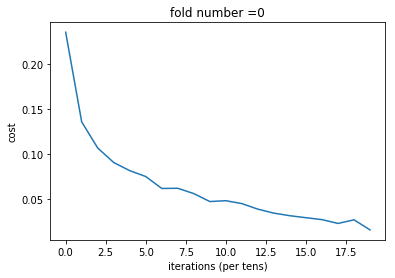

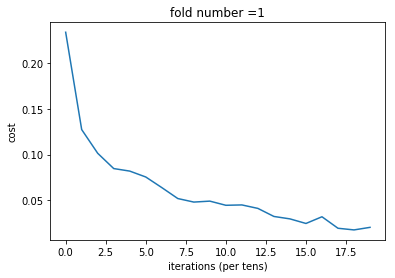

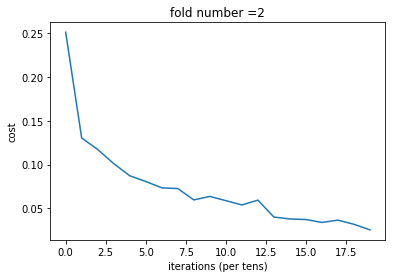

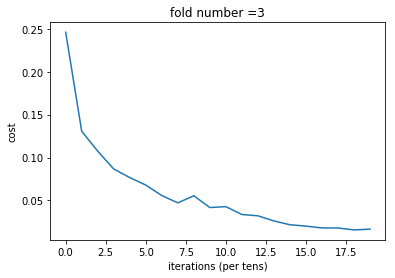

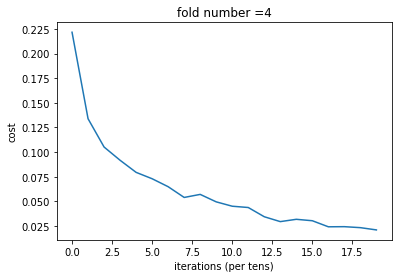

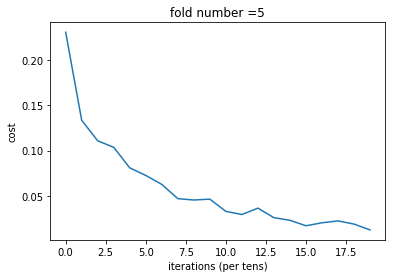

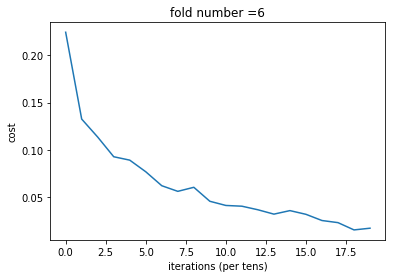

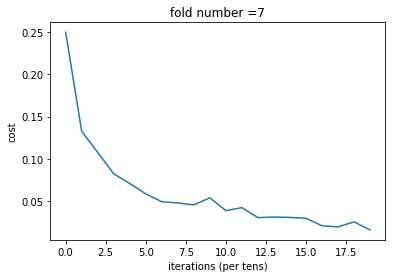

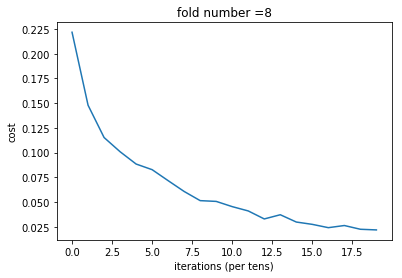

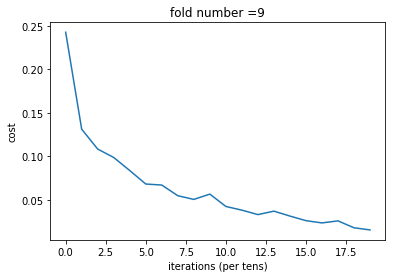

In [23]:
metric_dict = defaultdict(list)
#10-fold cross validation
kfold = KFold(10, True, 1)
for k, (train, test) in enumerate(kfold.split(full_data)):
    curr_train_X = full_data[train]
    curr_train_Y = full_labels_oh[train]
    curr_test_X = full_data[test]
    curr_test_Y = full_labels_oh[test]
    test_acc,test_recall,test_prec, f1_score = cactus_model_tf(curr_train_X, curr_train_Y, curr_test_X, curr_test_Y,
                    learning_rate = 0.009,
                    num_epochs = 20,
                    minibatch_size = 64, plt_flag=1,knum=k)
    metric_dict["test_acc"].append(test_acc)
    metric_dict["test_recall"].append(test_recall)
    metric_dict["test_prec"].append(test_prec)
    metric_dict["f1_score"].append(f1_score)

In [24]:
#finally examine the results of 10-fold CV in terms of the different metrics
metric_df = pd.DataFrame(metric_dict)
metric_df.describe()

,test_acc,test_recall,test_prec,f1_score
count,10.000000,10.000000,10.000000,10.000000
mean,0.981086,0.991476,0.994025,0.992645
std,0.012558,0.015586,0.010566,0.008237
min,0.950857,0.948420,0.965585,0.973527
25%,0.979000,0.992739,0.996221,0.993707
50%,0.987143,0.996830,0.998057,0.995759
75%,0.988000,0.999049,0.999275,0.997666
max,0.990286,0.999662,1.000000,0.998225
